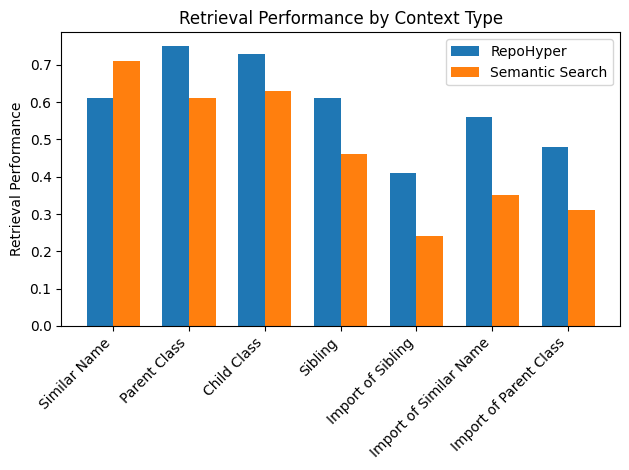

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import json

performance_data = json.loads("results_node_analysis.json")

context_types = list(performance_data.keys())
repo_hyper_scores = [performance_data[context]['RepoHyper'] for context in context_types]
semantic_search_scores = [performance_data[context]['SemanticSearch'] for context in context_types]

bar_width = 0.35
index = np.arange(len(context_types))

fig, ax = plt.subplots()
bar1 = ax.bar(index, repo_hyper_scores, bar_width, label='RepoHyper')
bar2 = ax.bar(index + bar_width, semantic_search_scores, bar_width, label='Semantic Search')


ax.set_ylabel('Retrieval Performance')
ax.set_title('Retrieval Performance by Context Type')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(context_types, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [2]:
import gzip
import pickle
from tqdm import tqdm
from typing import Union
import errno
import torch
import sys
import logging
import json
from pathlib import Path
import torch.distributed as dist
import csv
import os

ROOT = "/datadrive05/huypn16/knn-transformers/data/repobench"

def load_data(task:str, language:str, settings: Union[str, list]):
    """
    Load data from the specified task and language.

    Args:
        task: the task to load
        language: the language to load
        settings: the settings to load
    
    Returns:
        data: the loaded data
    """

    if task.lower() == 'r':
        task = 'retrieval'
    elif task.lower() == 'c':
        task = 'completion'
    elif task.lower() == 'p':
        task = 'pipeline'
    
    if language.lower() == 'py':
        language = 'python'
    
    if isinstance(settings, str):
        settings = [settings]
    
    for i, setting in enumerate(settings):
        if setting.lower() == 'xf-f':
            settings[i] = 'cross_file_first'
        elif setting.lower() == 'xf-r':
            settings[i] = 'cross_file_random'
        elif setting.lower() == 'if':
            settings[i] = 'in_file'
        

    # some assertions
    assert task.lower() in ['r', 'c', 'p', 'retrieval', 'completion', 'pipeline'], \
        "task must be one of R, C, or P"
    

    assert language.lower() in ['python', 'java', 'py'], \
        "language must be one of python, java"

    
    if task == "retrieval":
        assert all([setting.lower() in ['cross_file_first', 'cross_file_random'] for setting in settings]), \
            "For RepoBench-R, settings must be one of xf-f or xf-r"
    else:
        assert all([setting.lower() in ['cross_file_first', 'cross_file_random', 'in_file'] for setting in settings]), \
            "Settings must be one of xf-f, xf-r, or if"
    

    # load data
    data = {}
    # We split retrieval data into shards due to the github file size limit
    if task == "retrieval":
        for setting in tqdm(settings, desc=f"Loading data"):
            # we only further split the cross_file_first setting for java
            if setting == "cross_file_first" and language == "java":
                dic = {
                    "train": {},
                    "test": {}
                }
                with gzip.open(f"{ROOT}/{task}/{language}/{setting}_train_easy_1.gz", 'rb') as f:
                    train_easy_1 = pickle.load(f)
                with gzip.open(f"{ROOT}/{task}/{language}/{setting}_train_easy_2.gz", 'rb') as f:
                    train_easy_2 = pickle.load(f)
                dic['train']['easy'] = train_easy_1['easy'] + train_easy_2['easy']

                with gzip.open(f"{ROOT}/{task}/{language}/{setting}_train_hard_1.gz", 'rb') as f:
                    train_hard_1 = pickle.load(f)
                with gzip.open(f"{ROOT}/{task}/{language}/{setting}_train_hard_2.gz", 'rb') as f:
                    train_hard_2 = pickle.load(f)
                dic['train']['hard'] = train_hard_1['hard'] + train_hard_2['hard']

                with gzip.open(f"{ROOT}/{task}/{language}/{setting}_test.gz", 'rb') as f:
                    test = pickle.load(f)
                dic['test'] = test['test']
        
            
                data[setting] = dic
        
            else:
                dic = {
                    "train": {},
                    "test": {}
                }
                with gzip.open(f"{ROOT}/{task}/{language}/{setting}_train_easy.gz", 'rb') as f:
                    train_easy = pickle.load(f)
                dic['train']['easy'] = train_easy['easy']

                with gzip.open(f"{ROOT}/{task}/{language}/{setting}_train_hard.gz", 'rb') as f:
                    train_hard = pickle.load(f)
                dic['train']['hard'] = train_hard['hard']

                with gzip.open(f"{ROOT}/{task}/{language}/{setting}_test.gz", 'rb') as f:
                    test = pickle.load(f)
                dic['test'] = test['test']
        
                data[setting] = dic

    else:
        for setting in tqdm(settings, desc=f"Loading data"):
            with gzip.open(f"{ROOT}/{task}/{language}/{setting}.gz", 'rb') as f:
                data[setting] = pickle.load(f)
    
    if len(settings) == 1:
        return data[settings[0]]
    else:
        return [data[setting] for setting in settings]
    
logger = logging.getLogger(__name__)

In [3]:
language = "python"
task = "retrieval"

cross_file_first_hard = load_data(task, language, "cross_file_first")["train"]["hard"]

Loading data: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


In [5]:
cross_file_first_hard[1200]

{'repo_name': 'mrgambal/vulyk',
 'file_path': 'tests/gamification/test_donation.py',
 'context': ['class UserState:\n    """\n    An aggregation of all the stuff user has gotten working on projects so far.\n    """\n    __slots__ = [\n        \'user\',\n        \'level\',\n        \'points\',\n        \'actual_coins\',\n        \'potential_coins\',\n        \'achievements\',\n        \'last_changed\'\n    ]\n\n    def __init__(self,\n                 user: User,\n                 level: int,\n                 points: Decimal,\n                 actual_coins: Decimal,\n                 potential_coins: Decimal,\n                 achievements: list,\n                 last_changed: datetime) -> None:\n        """\n        :type user: User\n        :type level: int\n        :type points: Decimal\n        :type actual_coins: Decimal\n        :type potential_coins: Decimal\n        :type achievements: list[vulyk.blueprints.gamification.core.rules.Rule]\n        :type last_changed: datetime\n 

In [6]:
print(cross_file_first_hard[1200]["context"][cross_file_first_hard[1200]["gold_snippet_index"]])

class FixtureFund:
    FUND_ID = 'newfund'
    FUND_NAME = 'New fund'
    FUND_DESCRIPTION = 'description'
    FUND_SITE = 'site.com'
    FUND_EMAIL = 'email@email.ek'
    FUND_DONATABLE = True
    LOAD = b'iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAAAAbElEQVR' \
           b'4nO3Q0QmAMBAFwWitKSvFWsOKECIz/8c7dgwAAAAAAAAAAAAAADjHtW' \
           b'15zve3a333R3BvWT2UWIFYgViBWIFYgViBWIFYgViBWIFYgViBWIFYg' \
           b'ViBWIFYgVgAAAAAAAAAAAAAAPBTD1i3AiiQSFCiAAAAAElFTkSuQmCC'
    LOGO_BYTES = base64.b64decode(LOAD)

    @classmethod
    def get_fund(cls,
                 fund_id: str = FUND_ID,
                 name: str = FUND_NAME,
                 donatable: bool = FUND_DONATABLE) -> Fund:
        """
        :param fund_id: Fund ID
        :type fund_id: str
        :type name: Fund name
        :param donatable: Is donatable
        :type donatable: bool

        :return: Fully fledged fund instance
        :rtype: Fund
        """
        with TemporaryFile('w+b', suffix='.jpg') a

In [27]:
print(cross_file_first_hard[4500]["import_statement"])
print(cross_file_first_hard[4500]["code"])

import os
import subprocess
import traceback
import psutil
import win32process
import re
import wmi
import datetime
from settings import NETWORK_ADAPTATER
from utils.utils import write_to_output, get_csv_writer, write_to_json, close_json_writer, get_json_writer,\
     write_list_to_json, write_to_csv, get_terminal_decoded_string, record_sha256_logs, process_md5, process_sha1

    def _list_scheduled_jobs(self):
        proc = subprocess.Popen(["schtasks.exe", '/query', '/fo', 'CSV'], stdout=subprocess.PIPE,
                                stderr=subprocess.PIPE)
        res = proc.communicate()
        res = get_terminal_decoded_string(res[0])
        column_names = None
        for line in res.splitlines():
            if line == "":
                continue
            if line[0] != '"':
                continue
            if column_names is None:
                column_names = line
                continue
            elif column_names == line:
                continue
            